In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

## Demo 1 - Bayesian Lasso

In [5]:
n = 50
k = 100

np.random.seed(1234)
X = np.random.normal(size=(n, k))

beta = np.zeros(shape=k)
beta[[10,30,50,70]] =  10
beta[[20,40,60,80]] = -10

y = X @ beta + np.random.normal(size=n)

#### Weak-informative

In [32]:
with pm.Model() as bayes_weak:
    b = pm.Normal("beta", mu=0, sigma=10, shape=k)
    y_est = X @ b

    s = pm.HalfNormal("sigma", sd=2)
    y_ = pm.Normal("y", mu = y_est, sigma=s, observed=y)

In [34]:
with bayes_weak:
    trace = pm.sample(return_inferencedata=True, random_seed=12345)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


KeyboardInterrupt: 

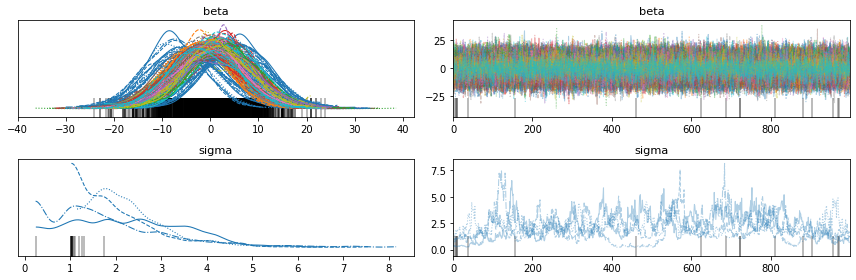

In [35]:
az.plot_trace(trace)
plt.tight_layout()

In [27]:
def plot_betas(trace):
    post = (
        trace.posterior["beta"]
        .to_dataframe()
        .reset_index()
        .query("chain == 0")
    )


    sns.catplot(
        x = "beta_dim_0", y="beta", data=post, kind="boxen", 
        linewidth=0, color="blue", aspect=2, showfliers=False
    )

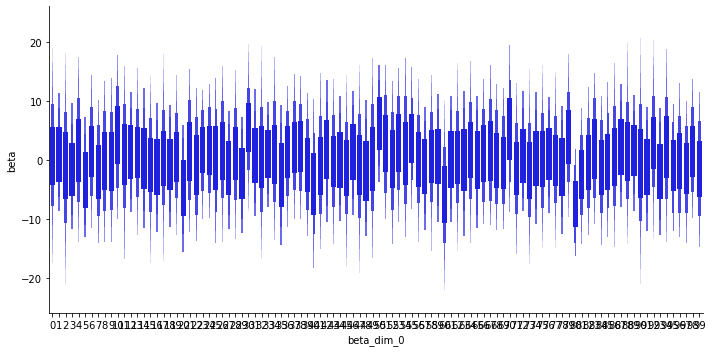

In [36]:
plot_betas(trace)

---

### Bayesian lasso


In [37]:
with pm.Model() as bayes_lasso:
    b = pm.Laplace("beta", 0, 1, shape=k) 
    y_est = X @ b

    s = pm.HalfNormal("sigma", sd=2)
    y_ = pm.Normal("y", mu = y_est, sigma=s, observed=y)

In [42]:
with bayes_lasso:
    trace = pm.sample(draws=2000, return_inferencedata=True, random_seed=54321)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.683394999808007, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [43]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.059,0.896,-1.549,1.900,0.019,0.019,2208.0,2054.0,1.00
beta[1],0.182,0.723,-1.312,1.502,0.019,0.014,1416.0,354.0,1.00
beta[2],-0.086,0.814,-1.664,1.545,0.014,0.012,3189.0,2416.0,1.00
beta[3],-0.288,0.787,-1.817,1.229,0.012,0.011,4069.0,2293.0,1.00
beta[4],0.069,0.806,-1.496,1.635,0.013,0.010,3729.0,4430.0,1.00
...,...,...,...,...,...,...,...,...,...
beta[96],0.049,0.725,-1.357,1.468,0.011,0.010,3841.0,2822.0,1.00
beta[97],-0.107,0.727,-1.473,1.314,0.015,0.011,2225.0,774.0,1.00
beta[98],0.244,0.739,-1.061,1.771,0.011,0.010,4923.0,2362.0,1.00
beta[99],-0.301,0.780,-1.897,1.080,0.018,0.017,2352.0,591.0,1.00


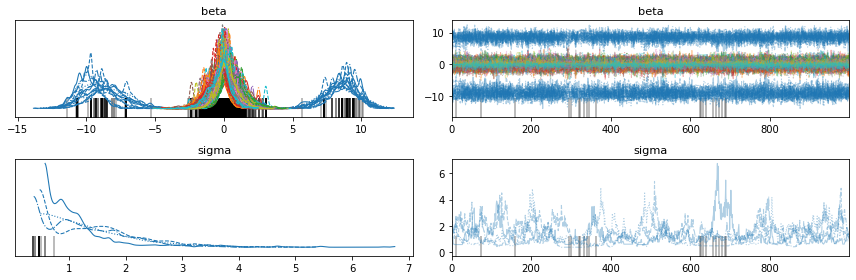

In [39]:
az.plot_trace(trace)
plt.tight_layout()

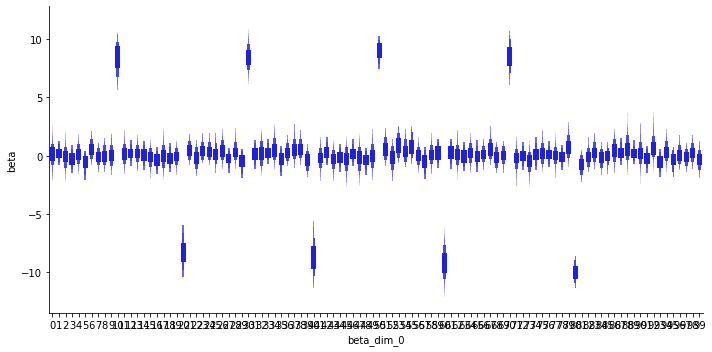

In [40]:
plot_betas(trace)

## Demo 2 - Gaussian Process

ExpQuad covariance function:

$\qquad k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]$

In [66]:
np.random.seed(12345)

n = 50
x = np.linspace(0, 1, n)
X = x.reshape(-1,1)

nugget = 0.75
sigma2_true = 4.0
l_true = 10

cov_func = sigma2_true * pm.gp.cov.ExpQuad(1, 1/l_true)
mean_func = pm.gp.mean.Zero()

y_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval(), 1
).flatten()

y = y_true + nugget * np.random.randn(n)

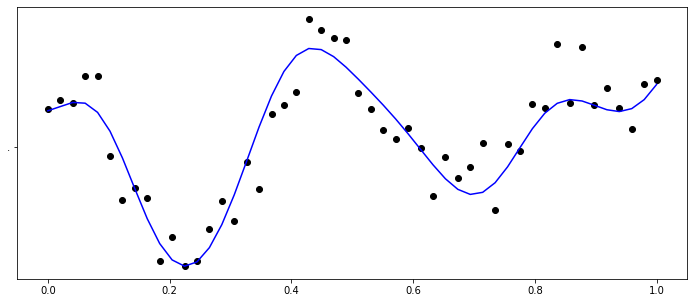

In [67]:
plt.figure(figsize=(12,5))
plt.plot(x,y, "ok",".")
plt.plot(x,y_true, "-b")
plt.show()

In [68]:
D = np.array([ np.abs(x1 - x) for x1 in x])
D0 = (D == 0).astype("double")

In [69]:
with pm.Model() as gp:
    nugget = pm.HalfCauchy("nugget", beta=5)
    sigma2 = pm.HalfCauchy("sigma2", beta=5)
    inv_l  = pm.HalfCauchy("inv_l",  beta=5)

    Sigma = D0 * nugget + sigma2 * np.exp(-0.5 * D**2 * inv_l**2)

    y_ = pm.MvNormal("y", mu=np.zeros(n), cov=Sigma, observed=y)


In [71]:

with gp:
    step = pm.NUTS([nugget, sigma2, inv_l])

    trace = pm.sample(
        return_inferencedata=True,
        chains = 2,
        step = step
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [inv_l, sigma2, nugget]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


array([[<AxesSubplot:title={'center':'nugget'}>,
        <AxesSubplot:title={'center':'nugget'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'sigma2'}>],
       [<AxesSubplot:title={'center':'inv_l'}>,
        <AxesSubplot:title={'center':'inv_l'}>]], dtype=object)

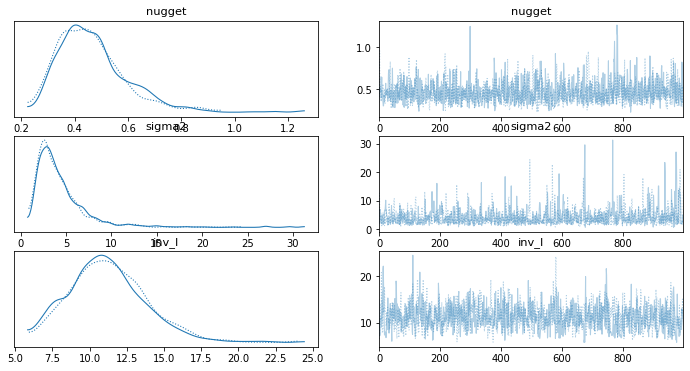

In [72]:
az.plot_trace(trace)

In [57]:

with gp:
    step = pm.Slice([nugget, sigma2, inv_l])

    trace_sl = pm.sample(
        return_inferencedata=True,
        chains = 2,
        step = step
    )

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Slice: [inv_l]
>Slice: [sigma2]
>Slice: [nugget]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


In [58]:

with gp:
    step = pm.Metropolis([nugget, sigma2, inv_l])

    trace_mh = pm.sample(
        return_inferencedata=True,
        chains = 2,
        step = step
    )

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [inv_l]
>Metropolis: [sigma2]
>Metropolis: [nugget]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'nugget'}>,
        <AxesSubplot:title={'center':'nugget'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'sigma2'}>],
       [<AxesSubplot:title={'center':'inv_l'}>,
        <AxesSubplot:title={'center':'inv_l'}>]], dtype=object)

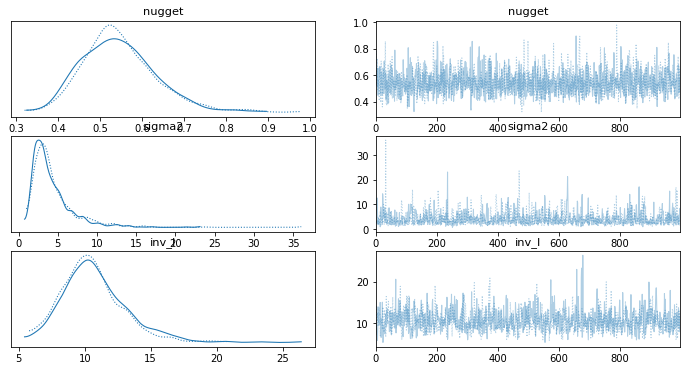

In [59]:
az.plot_trace(trace_sl)

array([[<AxesSubplot:title={'center':'nugget'}>,
        <AxesSubplot:title={'center':'nugget'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'sigma2'}>],
       [<AxesSubplot:title={'center':'inv_l'}>,
        <AxesSubplot:title={'center':'inv_l'}>]], dtype=object)

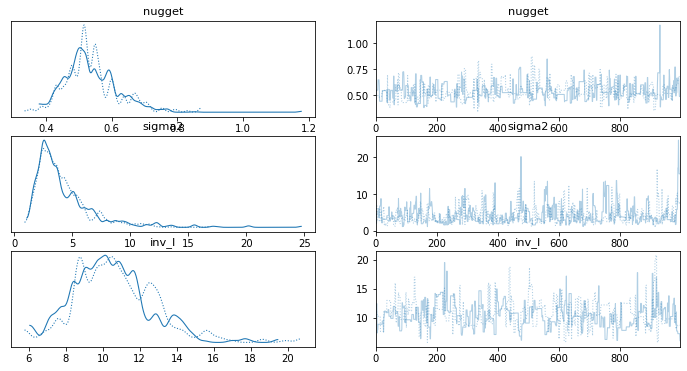

In [60]:
az.plot_trace(trace_mh)

In [62]:
az.summary(trace_mh)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nugget,0.538,0.081,0.415,0.701,0.004,0.003,347.0,275.0,1.01
sigma2,4.203,2.462,1.245,8.736,0.150,0.106,273.0,391.0,1.00
inv_l,10.604,2.153,6.840,14.400,0.151,0.107,193.0,333.0,1.01


In [63]:
az.summary(trace_sl)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nugget,0.545,0.087,0.399,0.713,0.002,0.001,1827.0,1522.0,1.0
sigma2,4.242,2.681,1.074,9.025,0.087,0.061,1000.0,1187.0,1.0
inv_l,10.675,2.404,6.023,14.804,0.078,0.055,941.0,1177.0,1.0


----

### PyMC Marginal GP implementation

In [75]:
with pm.Model() as gp_marginal:
    nugget = pm.HalfCauchy("nugget", beta=5)
    sigma2 = pm.HalfCauchy("sigma2", beta=5)
    inv_l  = pm.HalfCauchy("inv_l",  beta=5)

    cov = sigma2 * pm.gp.cov.ExpQuad(input_dim=1, ls=1/inv_l)
    gp = pm.gp.Marginal(cov_func = cov)

    # X and y must be np.arrays 
    y_ = gp.marginal_likelihood("y", X, y, noise=nugget)


In [77]:
with gp_marginal:
    trace = pm.sample(
        return_inferencedata=True,
        chains=2
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [inv_l, sigma2, nugget]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


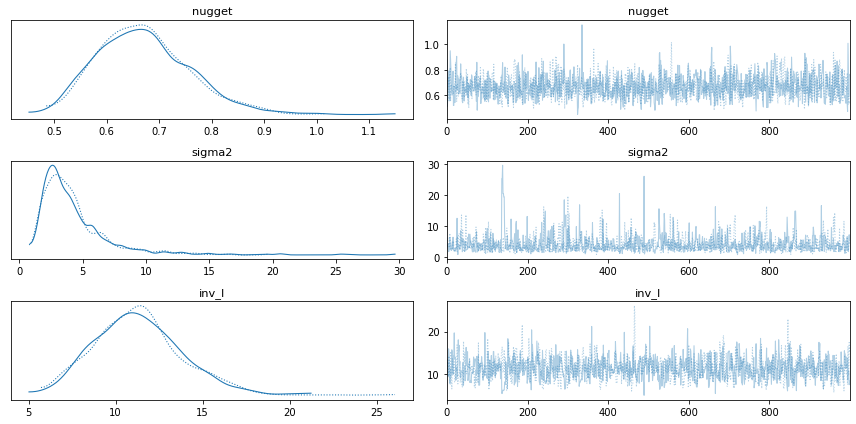

In [79]:
ax = az.plot_trace(trace)
plt.tight_layout()

In [80]:
with gp_marginal:
    mp = pm.find_MAP()

In [84]:
X_pred = np.linspace(0, 1, 1000).reshape(-1, 1)

with gp_marginal:
    y_pred = gp.conditional("y_pred", X_pred)


In [86]:
with gp_marginal:
    pp_trace = pm.sample_posterior_predictive([trace], var_names=["y_pred"], samples=500)

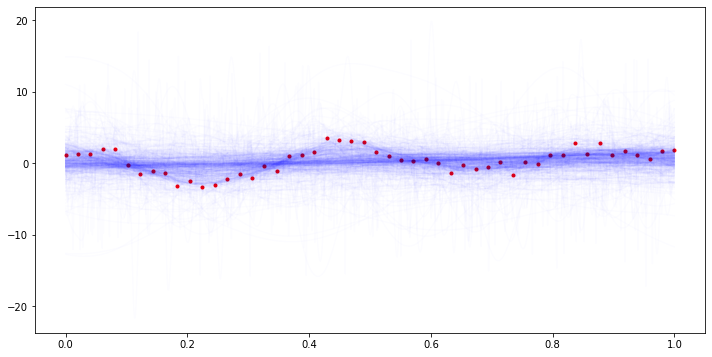

In [87]:
plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
plt.plot(X_pred, pp_trace["y_pred"].T, '-b', alpha=0.01)
plt.show()

In [88]:
with gp_marginal:
    pp_mp = pm.sample_posterior_predictive([mp], var_names=["y_pred"], samples=500)

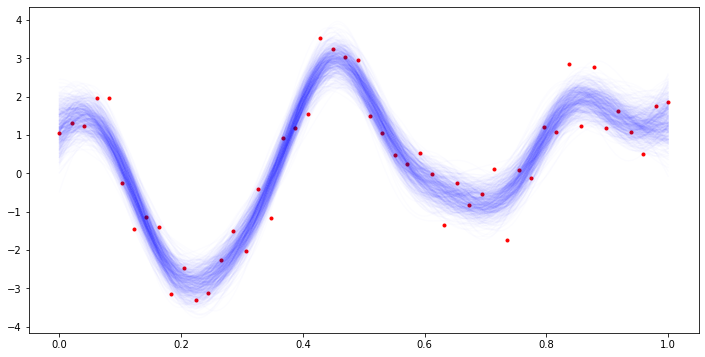

In [89]:
plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
plt.plot(X_pred, pp_mp["y_pred"].T, '-b', alpha=0.01)
plt.show()

In [91]:
res = []
for i in range(500):
    test = {
        'nugget': trace.posterior["nugget"].values[0,i],
        'sigma2': trace.posterior["sigma2"].values[0,i],
        'inv_l':  trace.posterior["inv_l"].values[0,i]
    }
    
    with gp_marginal:
        pp_test = pm.sample_posterior_predictive([test], var_names=["y_pred"], samples=1, progressbar=False)
    
    res.append(pp_test["y_pred"])

res = np.array(res).reshape(500,-1)

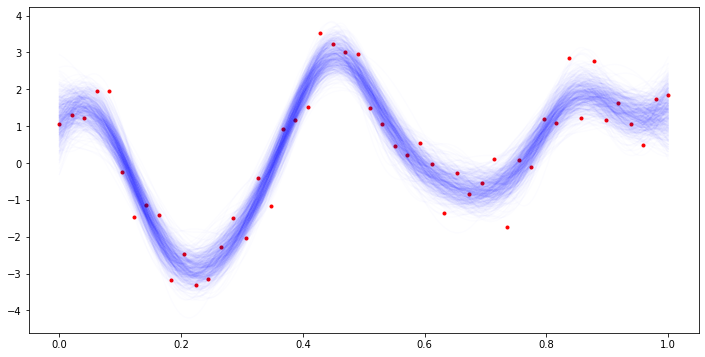

In [92]:
plt.figure(figsize=(12,6))
plt.plot(x,y,".r")
plt.plot(X_pred, res.T, '-b', alpha=0.01)
plt.show()